<a href="https://colab.research.google.com/github/RoFree/RFI_Propogation/blob/main/RFI_path_prop_sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assumptions



1.   Array lies on plane
2.   Curvature of the earth is negligible when considering antenna positions relative to each other (ie. antenna plane establishes x,y plane)
3.   RFI is sufficiently narrowband such that the path loss can assumed to be constant across frequency
4.   Tracking delay is constant across 1.5 sec (it varies a little so we calculate the tracking delay over the entire sampling interval and average it to get a rough ballpark, we could include it but then we'd need to optimize a lot)





# Deviations from matlab code

(note the calls to .value and then the addition of units back to the array after are a workaround between how astropy units and numpy arrays work)

*   Only calculating dcorr once
*   Vectorized dcorr, bline, and ang calc to take only a couple sec (execution time dropped to ~25 min from >45 min)
*    Dcorr is size nAnts*(nAnts+1)/2 and doesn't include baselines between adjacent antennas, I don't really get why the original code included that
*    Path attenuation is analytical per ITU-R P.452 (16), it won't be a perfect simulation (no ray tracing, etc.)

# Things I don't get







In [ ]:
#Ron Freeman. All rights reserved.
import random
import numpy as np
import scipy.signal as sig
import scipy
import astropy as astro
from astropy.coordinates import EarthLocation, SkyCoord, AltAz, offset_by
from astropy.time import Time, TimeDelta
from astropy import units as u
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import shutil

try:
    from casacore.tables import table
except ModuleNotFoundError or ImportError:
    !pip install python-casacore
    from casacore.tables import table

try:
    import rarfile
except ModuleNotFoundError or ImportError:
    !pip install rarfile
    import rarfile

try:
    from pycraf import pathprof
    from pycraf import conversions as cnv
    import pycraf

except ModuleNotFoundError or ImportError:
    !pip install pycraf
    import pycraf
    from pycraf import pathprof
    from pycraf import conversions as cnv


######################
# User Settings Here #
######################

PLOTON = 1
c = astro.constants.c
RFI_freq = 882.5 * 1e6 * u.Hz #RFI center freq
ArrDiam = 5 #antenna dish diameter
N_RFI_CHAN = 84
RFI_BW = 11.3636*1e6*u.Hz
INTEGRATION_TIME = 1.5
ANT_RADIUS = 2.5
ANT_EFFICIENCY = 0.7
SITE_LOCATION = EarthLocation(lat='38.4433', lon='-116.2731', height=1563) #generic for hot creek valley, can specify exact later
TARGET = SkyCoord('19h59m28.3566s', '40d44m2.096s')
START_TIME = Time('2023-07-28 00:00:00')
LTEdist = 36300 * u.m #aggressor antenna distance from center of array
LTEang = 165 * u.deg #angle of antenna (cardinal) from N of array
LTEheight = 80 * u.m #height of aggressor antenna relative to height of array (assumes array zero reference)

#Array pointing settings
ArrEl = 70
ArrAz = 180
PtError = 0

PYCRAF_SIM = 0 #if 1 we simulated with terrain propogation per https://www.itu.int/rec/R-REC-P.452-16-201507-I/en, if 0 use simple FSPL assuming no terrain effects.

################
# End Settings #
################

#you shouldn't need to change anything past this
def earth_offset(e_loc, bearing, dist, h, R=6378137*u.m):
    """
    Since the LTE transmitter is pretty close to the array, let's be flat earthers
    and calculate lat/lon offsets pretending the earth is flat. This should yield
    < 10 m accuracy across reasonable distances.
    Source: https://stackoverflow.com/questions/7222382/get-lat-long-given-current-point-distance-and-bearing
    Expects:
        (astropy.coordinates.EarthLocation): Location of reference point
        (astropy.units.Angle):Bearing angle to LTE station
        (astropy.units.Distance): Distance to LTE station
    Returns:
        (astropy.coordinates.EarthLocation): Offset location
    """

    lat_offset = np.arcsin(np.sin(e_loc.lat)*np.cos(dist/R*u.rad) + np.cos(e_loc.lat)*np.sin(dist/R*u.rad)*np.cos(bearing) )
    lon_offset = e_loc.lon + np.arctan2(np.sin(bearing)*np.sin(dist/R*u.rad)*np.cos(e_loc.lat), np.cos(dist/R*u.rad)-np.sin(e_loc.lat)*np.sin(lat_offset))
    return EarthLocation(lat=lat_offset, lon=lon_offset, height=h)

LTE_LOCATION = earth_offset(SITE_LOCATION, LTEang, LTEdist, LTEheight)


TEMPLATE_MS = '/content/1-chan-template.ms'
NOISE_MS = '/safepool/yuping/rfi_sim/1-chan-noise.ms'
IMG_NAME = "rfi-1350MHz-1chan"
#only run if we haven't configured things yet
try:
    if SETUP_DONE:
        print("already finished setup")
except Exception as e:
    !rm -rf dsa2000_rfi_files
    !git clone https://github.com/RoFree/dsa2000_rfi_files.git
    !cp dsa2000_rfi_files/* .
    rfi_chan_dat = scipy.io.loadmat("channelized_rfi.mat")

    !apt-get install wsclean
    #set openBLAS to single threaded for ws clean
    os.environ["OPENBLAS_NUM_THREADS"] = "1"

    #utility to export visibility data
    def vis_to_ms(vis_data, ms_path: str, add_noise=False):
        shutil.copytree(TEMPLATE_MS, ms_path)
        real, imag = vis_data
        vis = (real + 1j * imag)
        # some reshaping
        vis = vis[:, None, None] * np.array([1, 0, 0, 0])[None, None, :]
        if add_noise:
            with table(NOISE_MS, readonly=True) as noise_t:
                noise_vis = noise_t.getcol('DATA')
            vis += noise_vis
        with table(ms_path, readonly=False) as t:
            t.putcol('DATA', vis)

    #unpacks template .ms file
    !pip install rarfile

    with rarfile.RarFile('1-chan-template.ms.rar') as archive:
        archive.extractall()

    SETUP_DONE = 1



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.3/35.3 MB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 12.8 MB/s eta 0:00:00
Cloning into 'dsa2000_rfi_files'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 18 (delta 1), reused 8 (delta 1), pack-reused 9
Receiving objects: 100% (18/18), 92.97 MiB | 55.09 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Filtering content: 100% (2/2), 951.78 MiB | 53.98 MiB/s, done.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  casacore-data casacore-data-igrf casacore-data-jpl-de200
  casacore-data-jpl-de405 casacore-data-lines casacore-data-observatories
  casacore-data-sources casacore-data-tai-utc libcasa-casa6
  libcasa-coordinates6 libcasa-derivedmscal6 libcasa-fits6 libcasa-images6
  libcasa-lattices6 libcasa-mea

# Main Simulation Script


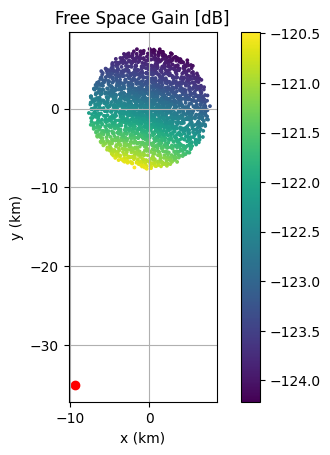

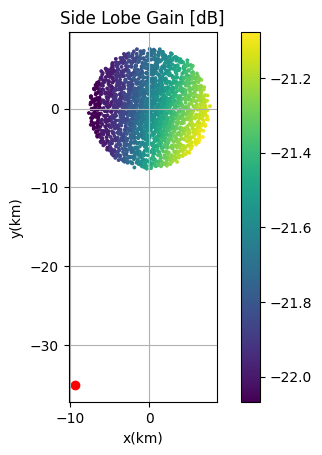

100%|██████████| 84/84 [00:00<00:00, 238.47it/s]


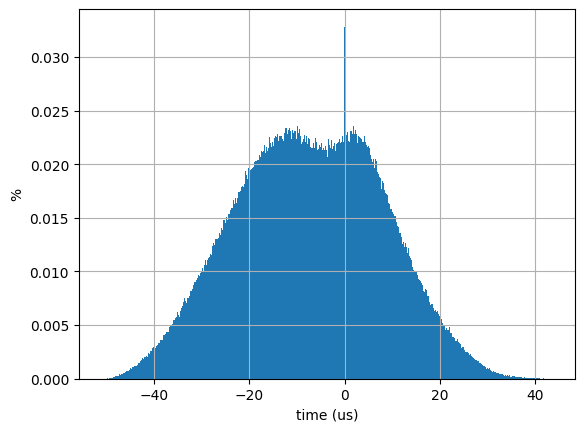

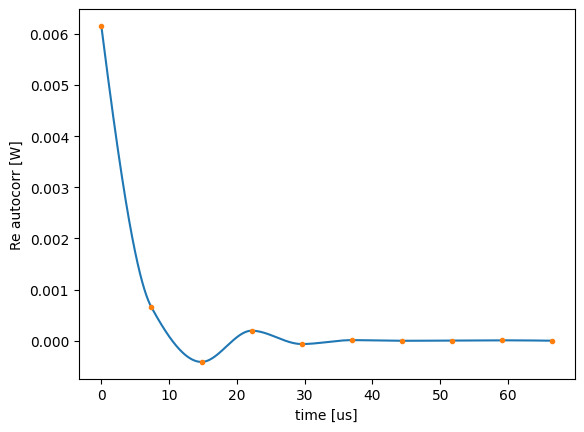

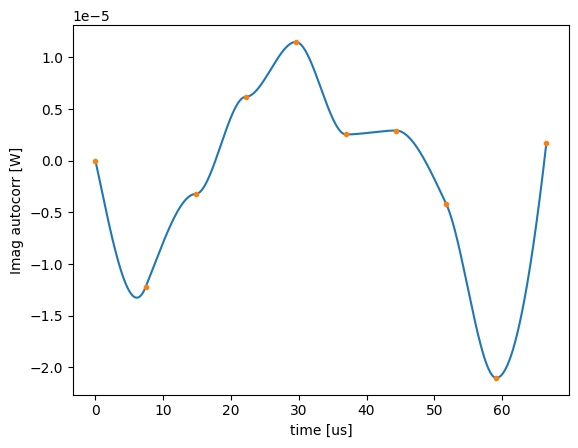

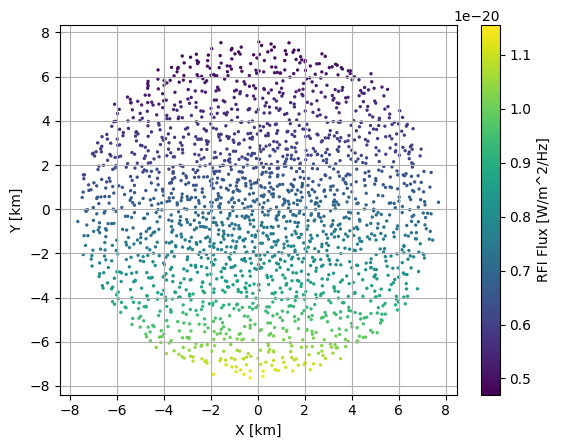

alpha max min [3.3609160542241932e-21, 1.3675285151053032e-21]
acf max min [(3.43629556094285+0j), (3.43629556094285+0j)]
RFI flux max min [1.1549100917832154e-20, 4.699232165919121e-21]


100%|██████████| 84/84 [15:56<00:00, 11.39s/it]


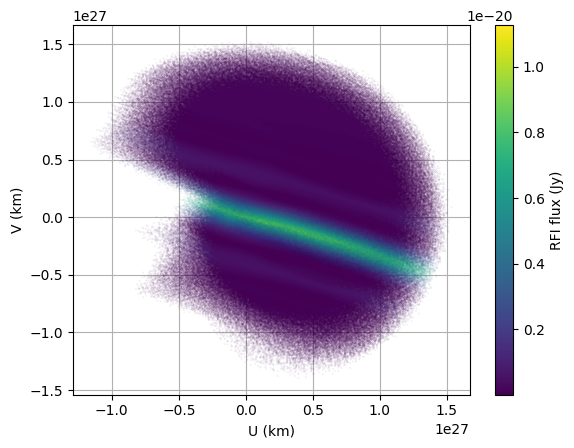

rm: cannot remove '*.fits': No such file or directory
Successful read/write open of default-locked table results.ms: 22 columns, 2096128 rows


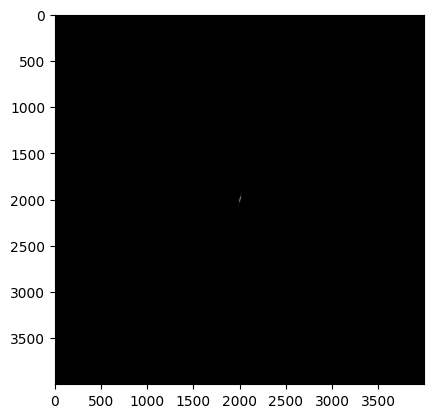

In [ ]:
#Ron Freeman. All rights reserved.

import time
trig_sum = lambda x:  x*(x-1)//2
trig_sum_inc = lambda x: x*(x+1)//2

rfi_chan = np.copy(rfi_chan_dat['rfi_chan'])

rfi_chan *= 10**(-INTEGRATION_TIME) #don't fully understand this
rfi_chan = scipy.fft.fftshift(rfi_chan, axes=1)


ants = np.loadtxt("20210226W.csv", delimiter=",") * u.m #lack of heights neccesitates assumption #1 and #2
nAnts = len(ants)
locs = earth_offset(SITE_LOCATION, np.arctan2(ants[:, 1], ants[:, 0]), np.sqrt(ants[:, 0]**2 + ants[:, 1]**2), h=0)

LTE = [LTEdist*np.cos(LTEang+np.pi/2*u.rad), LTEdist*np.sin(LTEang+np.pi/2*u.rad), LTEheight]

if PYCRAF_SIM:
    #loss sim stuff, mostly from https://nbviewer.org/github/bwinkel/pycraf/blob/master/notebooks/03a_path_propagation_basic.ipynb
    #and https://nbviewer.org/github/bwinkel/pycraf/blob/master/notebooks/03c_attenuation_maps.ipynb
    pycraf.pathprof.SrtmConf.set(download='missing', server='viewpano', srtm_dir='.')

    #get our location data
    lons, lats, heightmap = pathprof.srtm_height_map(
        LTE_LOCATION.lon, LTE_LOCATION.lat,
        1*u.deg, 1*u.deg,
        map_resolution=1.*u.arcsec,
        )

    if PLOTON:
        _lons = lons.to(u.deg).value
        _lats = lats.to(u.deg).value
        _heightmap = heightmap.to(u.m).value

        vmin, vmax = 0, 5000
        terrain_cmap, terrain_norm = pathprof.terrain_cmap_factory(vmin=vmin, vmax=vmax)

        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_axes((0., 0., 1.0, 1.0))
        cbax = fig.add_axes((0., 0., 1.0, .02))
        cim = ax.imshow(
            _heightmap,
            origin='lower', interpolation='nearest',
            cmap=terrain_cmap, norm=terrain_norm,
            extent=(_lons[0], _lons[-1], _lats[0], _lats[-1]),
            )
        cbar = fig.colorbar(
            cim, cax=cbax, orientation='horizontal'
            )
        ax.set_aspect(abs(_lons[-1] - _lons[0]) / abs(_lats[-1] - _lats[0]))
        ctics = np.arange(0, vmax, 500)
        cbar.set_ticks(ctics)
        cbar.ax.set_xticklabels(map('{:.0f} m'.format, ctics), color='k')
        cbar.set_label(r'Height (amsl)', color='k')
        cbax.xaxis.tick_top()
        cbax.xaxis.set_label_position('top')
        ax.set_xlabel('Longitude [deg]')
        ax.set_ylabel('Latitude [deg]')
        ax.xaxis.tick_top()
        ax.xaxis.set_label_position('top')
        ax.annotate(
                "Center of array", xy=(SITE_LOCATION.lon.value, SITE_LOCATION.lat.value), xytext=(10, 10),
                textcoords='offset points', color="k",
                arrowprops=dict(arrowstyle="->", color="k")
                )
        ax.annotate(
                "LTE Transmitter", xy=(LTE_LOCATION.lon.value, LTE_LOCATION.lat.value), xytext=(10, 10),
                textcoords='offset points', color="k",
                arrowprops=dict(arrowstyle="->", color="k")
                )
        ax.scatter(locs.lon, locs.lat, s=1)
        plt.show()

    freq = RFI_freq
    omega = 0. * u.percent  # fraction of path over sea
    temperature = 290. * u.K
    pressure = 1013. * u.hPa
    timepercent = 2 * u.percent  # see P.452 for explanation
    h_tg, h_rg = 50 * u.m, 10 * u.m
    G_t, G_r = 0 * cnv.dBi, 0 * cnv.dBi
    zone_t, zone_r = pathprof.CLUTTER.SPARSE, pathprof.CLUTTER.SPARSE
    hprof_step = 5 * u.m  # if made large, Gaussian smoothing is applied to avoid aliasing

    hprof_cache = pathprof.height_map_data(
        LTE_LOCATION.lon, LTE_LOCATION.lat,
        1*u.deg, 1*u.deg,
        map_resolution=5.*u.arcsec,
        zone_t=zone_t, zone_r=zone_r,
        )

    atten_map = pathprof.atten_map_fast(
        freq,
        temperature,
        pressure,
        h_tg, h_rg,
        timepercent,
        hprof_cache,  # dict_like
        )

    if PLOTON:
        _lons = hprof_cache['xcoords']
        _lats = hprof_cache['ycoords']
        _total_atten = atten_map['L_b']  # see description of atten_map_fast

        vmin, vmax = 50, 250
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_axes((0., 0., 1.0, 1.0))
        cbax = fig.add_axes((0., 0., 1.0, .02))
        cim = ax.imshow(
            _total_atten.to(cnv.dB).value,
            origin='lower', interpolation='nearest', cmap='inferno_r',
            vmin=vmin, vmax=vmax,
            extent=(_lons[0], _lons[-1], _lats[0], _lats[-1]),
            )
        cbar = fig.colorbar(
            cim, cax=cbax, orientation='horizontal'
            )
        ax.set_aspect(abs(_lons[-1] - _lons[0]) / abs(_lats[-1] - _lats[0]))

        ctics = np.arange(0, vmax, 20)
        cbar.set_ticks(ctics)
        cbar.ax.set_xticklabels(map('{:.0f} dB'.format, ctics), color='w')
        cbar.set_label(r'Path propagation loss', color='w')
        cbax.xaxis.tick_top()
        cbax.tick_params(axis='x', colors='w')
        cbax.xaxis.set_label_position('top')

        ax.set_xlabel('Longitude [deg]')
        ax.set_ylabel('Latitude [deg]')

        ax.annotate(
                "Center of array", xy=(SITE_LOCATION.lon.value, SITE_LOCATION.lat.value), xytext=(10, 10),
                textcoords='offset points', color="k",
                arrowprops=dict(arrowstyle="->", color="k")
                )
        ax.annotate(
                "LTE Transmitter", xy=(LTE_LOCATION.lon.value, LTE_LOCATION.lat.value), xytext=(10, 10),
                textcoords='offset points', color="k",
                arrowprops=dict(arrowstyle="->", color="k")
                )
        ax.xaxis.tick_top()
        ax.xaxis.set_label_position('top')
        ax.scatter(locs.lon, locs.lat, s=1)
        plt.show()

    FSPL = np.zeros((nAnts))
    atten_map_interp = scipy.interpolate.RectBivariateSpline(hprof_cache['xcoords'], hprof_cache['ycoords'], atten_map['L_b'])
    for a in tqdm(range(nAnts)):
        FSPL[a] = 10**(atten_map_interp(locs[a].lon, locs[a].lat)/10)
else:
    #doing this with FSPL (not neccesarily true in the future)
    FSPL = np.zeros((nAnts))
    for a in range(nAnts):
        d = np.sqrt( (ants[a, 0] - LTE[0])**2 + (ants[a, 1] - LTE[1])**2 + (0-LTE[2])**2)
        FSPL[a] = (np.square((4*np.pi*d*RFI_freq))/c**2)**(-1) #implies assumption #3

ant_model = scipy.io.loadmat("Patterns_dBi_27Freq_3Models (1) (1).mat")
I = np.argmin(np.abs(ant_model["freqListGHz"]*u.GHz - RFI_freq))
SLA = np.zeros(nAnts)
ArrSteer = np.array([np.sin(np.pi/2 - np.deg2rad(ArrEl + PtError*random.random()))*np.sin(np.deg2rad(ArrAz + PtError*random.random())),
                    np.sin(np.pi/2-np.deg2rad(ArrEl+PtError*random.random()))*np.cos(np.deg2rad(ArrAz+PtError*random.random())),
                    np.cos(np.pi/2 - np.deg2rad(ArrEl+PtError*random.random()))
                    ])
normArrSteer = np.sqrt(np.asmatrix(ArrSteer)*np.asmatrix(ArrSteer).H) #need to understand what this is doing
for k in range(nAnts):
    vec = np.array([(ants[k, 0]-LTE[0]).value, (ants[k, 1] - LTE[1]).value, -1*LTE[2].value])*u.m
    ang = np.dot(ArrSteer, vec) / np.sqrt(np.dot(vec, vec)) / normArrSteer
    ang = np.arccos(ang)
    idx = np.argmin(np.abs(ant_model["ThetaDeg"] - np.rad2deg(ang).value))
    SLA[k] = 10**(ant_model["coPolPattern_dBi_Freqs_15DegConicalShield"][idx, 0, I]/10) #get effective gain and make linear (db --> lin)

if PLOTON:
    plt.figure()
    plt.scatter(ants[:, 0]/1e3, ants[:, 1]/1e3, 3, 10*np.log10(FSPL))
    plt.colorbar()
    plt.xlabel("x (km)")
    plt.gca().set_aspect('equal')
    plt.ylabel("y (km)")
    plt.grid()
    plt.scatter(LTE[0]/1e3, LTE[1]/1e3, c="red")
    plt.title("Free Space Gain [dB]")
    plt.plot()
    plt.figure()
    plt.scatter(ants[:, 0]/1e3, ants[:, 1]/1e3, 3, 10*np.log10(SLA))
    plt.colorbar()
    plt.xlabel("x(km)")
    plt.ylabel("y(km)")
    plt.grid()
    plt.gca().set_aspect('equal')
    plt.scatter(LTE[0]/1e3, LTE[1]/1e3, c="red")
    plt.title("Side Lobe Gain [dB]")
    plt.show()

#finds baselines for all elements in the array and time shift vecotr
# 3d array with phase shift multipliers for each antenna in the array
df = RFI_BW/N_RFI_CHAN #get fs for each rfi chan
times = np.linspace(0, rfi_chan.shape[1]/df.value, num=rfi_chan.shape[0])
t = START_TIME+TimeDelta(times*u.s)
aa = TARGET.transform_to(AltAz(location=SITE_LOCATION, obstime=t))
target_vecs = np.array([np.sin(aa.alt)*np.cos(aa.az), np.sin(aa.alt)*np.cos(aa.az), np.cos(aa.alt)])

idx = 0
dcorr = np.zeros((trig_sum_inc(nAnts))) #array will loop n*(n+1)/2 times, so pre allocating improves speed
b_vecs = np.zeros((trig_sum_inc(nAnts), 3))
for k in tqdm(range(nAnts)):
    assert idx <= len(dcorr)
    dcorr[idx:idx+nAnts-k-1] = (np.sqrt( (ants[k+1:, 0] - LTE[0])**2 + (ants[k+1:, 1] - LTE[1])**2 + (LTE[2])**2) - \
          np.sqrt((ants[k, 0] - LTE[0])**2 + (ants[k, 1] - LTE[1])**2 + (0-LTE[2])**2) ).value
    b_vecs[idx:idx+nAnts-k-1, 0] = ants[k+1:, 0] - ants[k, 0]
    b_vecs[idx:idx+nAnts-k-1, 1] = ants[k+1:, 1] - ants[k, 1]
    idx += nAnts-k-1

dcorr *= u.m

if PLOTON:
    plt.figure()
    plt.hist(dcorr/c*1e6, bins=1000, density=True)
    plt.grid()
    plt.xlabel("time (us)")
    plt.ylabel("%")


sam1_5 = round(INTEGRATION_TIME*(RFI_BW.value/N_RFI_CHAN)) #finds number of samples coresponding to 1.5 sec of integration
acf_fil = np.zeros((rfi_chan.shape[1], 10), dtype=complex) #why 10
for kk in tqdm(range(rfi_chan.shape[1])):
    rfi_fil = rfi_chan[:, kk].T
    for k in range(10):
        acf_fil[kk, k] = np.matmul(np.asmatrix(rfi_fil[:sam1_5]), np.asmatrix(rfi_fil[k:sam1_5+k]).H).item() / len(rfi_fil[:sam1_5]) #finds autocorrelation as x*x' after filtering??

t_acf = np.arange(0, acf_fil.shape[1])
ovsam = np.arange(0, t_acf[-1], step=1/1000)
acf_interp = np.zeros((acf_fil.shape[0], len(ovsam)), dtype=complex)
for k in range(acf_interp.shape[0]):
    acf_interp[k, :] = scipy.interpolate.PchipInterpolator(t_acf, acf_fil[k, :])(ovsam)

if PLOTON:
    plt.figure()
    plt.plot(ovsam/(RFI_BW/N_RFI_CHAN)*1e6,np.real(acf_interp[10,:]))
    plt.plot(t_acf/(RFI_BW/N_RFI_CHAN)*1e6, np.real(acf_fil[10,:]), ".")
    plt.xlabel("time [us]")
    plt.ylabel("Re autocorr [W]")
    plt.figure()
    plt.plot(ovsam/(RFI_BW/N_RFI_CHAN)*1e6,np.imag(acf_interp[10,:]))
    plt.plot(t_acf/(RFI_BW/N_RFI_CHAN)*1e6, np.imag(acf_fil[10,:]), ".")
    plt.xlabel("time [us]")
    plt.ylabel("Imag autocorr [W]")

alpha = np.zeros((nAnts, rfi_chan.shape[1]))
for k in range(rfi_chan.shape[1]):
    alpha[:, k] = np.multiply(SLA, FSPL.T)/(np.pi*(ANT_RADIUS**2)*ANT_EFFICIENCY*(RFI_BW/N_RFI_CHAN)) #this is rfi flux, with 135 kHz channels based on eq ɑ_path*ɑ_ant*rfi_pow/(lambda^2/4pi * g_ant * Bw)

if PLOTON:
    plt.figure()
    plt.scatter(ants[:, 0]/1e3, ants[:, 1]/1e3, 2, c=alpha[:,rfi_chan.shape[1]//2]*np.abs(acf_fil[rfi_chan.shape[1]//2, 0])) #just doing pow for center channel of the rfi
    plt.colorbar(label="RFI Flux [W/m^2/Hz]")
    plt.xlabel("X [km]")
    plt.ylabel("Y [km]")
    plt.grid()
    plt.plot()
    plt.show()
print(f"alpha max min {[np.max(alpha[:,rfi_chan.shape[1]//2]), np.min(alpha[:,rfi_chan.shape[1]//2])]}")
print(f"acf max min {[np.max(acf_fil[rfi_chan.shape[1]//2, 0]), np.min(acf_fil[rfi_chan.shape[1]//2, 0])]}")
print(f"RFI flux max min {[np.max(alpha[:,rfi_chan.shape[1]//2]*np.abs(acf_fil[rfi_chan.shape[1]//2, 0])), np.min(alpha[:,rfi_chan.shape[1]//2]*np.abs(acf_fil[rfi_chan.shape[1]//2, 0]))]}")
#finally, calculate the visibilities
vis = np.zeros((rfi_chan.shape[1], trig_sum(nAnts)), dtype=complex)
idx = 0
tcorr = dcorr/c
df = RFI_BW/N_RFI_CHAN #get fs for each rfi chan
target_vecs_mean = np.mean(target_vecs, axis=1)
time_shifts_tracking = np.sum(b_vecs*target_vecs_mean, axis=1)*u.m/c

tcorrsam = np.round((tcorr.value+time_shifts_tracking.value)*(RFI_BW.value/N_RFI_CHAN)*1e3).astype(np.int16)

#time_shifts_with_tracking_n_baseline = time_shifts_tracking + tcorr
#shift_factor = np.exp(-2j*np.pi*df*time_shifts_with_tracking_n_baseline)
#need to vectorize this
for kkk in tqdm(range(rfi_chan.shape[1])):
    #rfi_fil = np.tile(rfi_chan[:, kkk].T, (len(shift_factor), 1))
    for k in range(nAnts):
        for kk in range(k+1, nAnts):
            """
            temp = rfi_fil*shift_factor[idx] #assume samples are sampled at df
            acf = np.matmul(np.asmatrix(temp[:sam1_5]), np.asmatrix(temp[:sam1_5]).H).item() / len(temp[:sam1_5])
            vis[kkk, idx] = np.sqrt(alpha[k, kkk])*np.sqrt(alpha[kk, kkk])*acf #vis = loss(a)*loss(b)*corr_rfi(t)
            idx += 1
            """
            t = tcorrsam[idx] #baseline time shift
            if t < 0:
                vis[kkk, idx] = np.sqrt(alpha[k, kkk])*np.sqrt(alpha[kk, kkk])*np.conj(acf_interp[kkk, -1*t]) #vis = loss(a)*loss(b)*corr_rfi(t)
            else:
                vis[kkk, idx] = np.sqrt(alpha[k, kkk])*np.sqrt(alpha[kk, kkk])*(acf_interp[kkk, t]) #vis = loss(a)*loss(b)*corr_rfi(t)
            idx += 1
    idx = 0

bline = np.zeros((trig_sum(nAnts)))
ang = np.zeros((trig_sum(nAnts)))
idx = 0
#find mag and direction for vectors between
for k in range(nAnts):
    bline[idx:idx+nAnts-k-1] =  np.sqrt((ants[k, 0]-ants[k+1:, 0])**2 + (ants[k, 1]-ants[k+1:, 1])**2)
    ang[idx:idx+nAnts-k-1] = np.arctan2(ants[k, 1]-ants[k+1:, 1], ants[k, 0]- ants[k+1:, 0])
    idx += nAnts - k-1

if PLOTON:
    plt.figure()
    plt.rc('axes', axisbelow=True)
    plt.grid()
    plt.scatter(1e26*bline*np.cos(ang)/1e3, 1e26*bline*np.sin(ang)/1e3, s=0.001, c=np.abs(vis[vis.shape[0]//2, :]))
    plt.xlabel("U (km)")
    plt.ylabel("V (km)")
    plt.colorbar(label="RFI flux (Jy)")
    plt.show()

!rm -rf results.ms
!rm *.fits
vis_to_ms(np.array([np.real(vis[vis.shape[0]//2, :])*1e26, np.imag(vis[vis.shape[0]//2, :])*1e26]), 'results.ms')

#generate the image
os.system(f"wsclean -nwlayers 1 -no-update-model-required -niter 0 -size 4000 4000 -scale 0.8asec -weight natural -datacolumn DATA -name {IMG_NAME} results.ms")
#open it up and plot it
dat = astro.io.fits.open(f'{IMG_NAME}-image.fits')
img = dat[0].data[0, 0, :, :]
plt.imshow(img, cmap='gray')

# Misc

# Testing

In [ ]:
#rfi_chan = rfi_chan_dat['waveStruct'][0][0][-1] #gets the raw freq bins from the signal generated by the LTE toolbox
rfi_chan = rfi_chan_dat['rfi_chan']
rfi_chan *= 10**(-INTEGRATION_TIME) #don't fully understand this
rfi_chan = scipy.fft.fftshift(rfi_chan, axes=1)
df = RFI_BW/N_RFI_CHAN #get fs for each rfi chan
time_shifts_rad = -2*np.pi*df*np.linspace(0, rfi_chan.shape[1]/df, num=rfi_chan.shape[0]) #calculate delay in rad given by tau = - phase/ang_freq
time_shifts_rad = np.exp(1j*time_shifts_rad) #get our magic number to apply the phase shift using sin(theta)+jcos(theta) rotation
time_shifts_rad_m = np.tile(time_shifts_rad, (N_RFI_CHAN, 1)).T #copy array for each channel
#time_shifts_rad = np.tile(time_shifts_rad, (rfi_chan.shape[0], rfi_chan.shape[1]))

In [ ]:


df = RFI_BW/N_RFI_CHAN #get fs for each rfi chan
times = np.linspace(0, rfi_chan.shape[1]/df, num=rfi_chan.shape[0])
target_vecs = np.zeros((rfi_chan.shape[0], 3))
idx = 0
def calc_vecs(time):
    t = START_TIME+TimeDelta(time*u.s)
    aa = TARGET.transform_to(AltAz(location=SITE_LOCATION, obstime=t))
    return np.array([np.sin(aa.alt)*np.cos(aa.az), np.sin(aa.alt)*np.cos(aa.az), np.cos(aa.alt)])
target_vecs = np.apply_along_axis(calc_vecs, 0, times)

UnitConversionError: ignored